# Exploratory Data Analysis

In this notebook, we explore the data of the ar quality index in Rio de Janeiro city. From the results, we can have insights to the machine learning algorithm.  We devide the analyis in 

1. Understading the data: what the data looks like, what are the information we have and what we can use;
2. Data exploration: visualizing the data and looking for some patterns;
3. Data cleaning

## Understanding the data 

In order to analyse the data, we first load the necessary libraries and the data. 

In [1]:
import pandas as pd
import pandas_profiling as pp
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
sns.set()

%matplotlib inline

## Definitions cell

In [12]:
#matplotlib.use("pgf")
#matplotlib.rcParams.update({
    #"pgf.texsystem": "pdflatex",
    #'font.family': 'serif',
    #'text.usetex': True,
    #'pgf.rcfonts': False,
    #'font.serif' : "Times New Roman",
#})

IMAGES_FOLDER = "../notes/images/"

In [13]:
air_data = pd.read_csv("../data/RiodeJaneiro_MonitorAr_hourly.csv")
air_data.head()

,Data,CodNum,Estação,Chuva,Pres,RS,Temp,UR,Dir_Vento,Vel_Vento,...,NO,NOx,O3,PM10,PM2_5,Lat,Lon,X_UTM_Sirgas2000,Y_UTM_Sirgas2000,OBJECTID
0,2012/01/01 00:30:00+00,2,BG,0.2,1008.15,NaN,24.67,95.24,NaN,NaN,...,2.18,17.36,28.06,81.0,NaN,-22.88791,-43.471074,656828.8045,7.468075e+06,1
1,2012/01/01 01:30:00+00,2,BG,0.4,1007.13,NaN,24.72,94.13,NaN,NaN,...,1.63,11.12,32.81,61.0,NaN,-22.88791,-43.471074,656828.8045,7.468075e+06,2
2,2012/01/01 02:30:00+00,2,BG,0.0,1006.32,NaN,24.49,92.91,NaN,NaN,...,1.73,10.47,31.61,26.0,NaN,-22.88791,-43.471074,656828.8045,7.468075e+06,3
3,2012/01/01 03:30:00+00,2,BG,0.2,1005.82,NaN,24.54,92.59,NaN,NaN,...,1.18,6.68,37.39,20.0,NaN,-22.88791,-43.471074,656828.8045,7.468075e+06,4
4,2012/01/01 04:30:00+00,2,BG,0.4,1005.45,NaN,24.78,90.71,NaN,NaN,...,0.95,9.35,33.45,7.0,NaN,-22.88791,-43.471074,656828.8045,7.468075e+06,5


### Monitored parameters

* `Data`: Date of the observation. 
* `CodNun`: Station code. 
* `Estação`: One of the monitoring stations given below. 
* `Chuva`: Rainfall (mm).
* `Pres`: Atmospheric Pressure (mbar).
* `RS` : Solar radiation (w/m2).
* `Temp`: Temperature (° C).
* `UR`: Relative humidity (%).
* `Dir_Vento`: Wind direction (°)
* `Vel_Vento`: Wind speed (m/s)
* `Lat`: Latitude position of the station 
* `Lon`: Longitude position of the station 
* `X_UTM_Sirgas2000`: Latitude in the Sirgas 2000 referential
* `Y_UTM_Sirgas2000`: Longitude in the Sirgas 2000 referential
* `OBJECTID`: Enumeration

### Stations and monitored gases
---

- Centro (CA): O3, CO, PM10
- Copacabana (AV): SO2, O3, CO, PM10
- São Cristóvão (SC): SO2,  O3, CO, PM10
- Tijuca (SP): SO2, NOx, O3, CO, PM10
- Irajá (IR): SO2, NOx, O3, CO, HC, PM2.5, PM10
- Bangu (BG): SO2, NOx, O3, CO, HC, PM10
- Campo Grande (CG): SO2, NOx, O3, CO, HC, PM10
- Pedra de Guaratiba (PG): O3, PM10

CO and HC are measured in (ppm), while the others are measured in (µg/m3).

In [4]:
air_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 661662 entries, 0 to 661661
Data columns (total 26 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Data              661662 non-null  object 
 1   CodNum            661662 non-null  int64  
 2   Estação           661662 non-null  object 
 3   Chuva             645850 non-null  float64
 4   Pres              646368 non-null  float64
 5   RS                613402 non-null  float64
 6   Temp              591045 non-null  float64
 7   UR                551043 non-null  float64
 8   Dir_Vento         571164 non-null  float64
 9   Vel_Vento         570919 non-null  float64
 10  SO2               464874 non-null  float64
 11  NO2               271157 non-null  float64
 12  HCNM              200083 non-null  float64
 13  HCT               199993 non-null  float64
 14  CH4               200140 non-null  float64
 15  CO                547483 non-null  float64
 16  NO                27

From these informations we can already see that some features are redundants. For instance, OBJECTID is the same as id, so we can remove it. The same with the colums CodNum and Estação, Lat/Lon and X/Y_UTM_Sirgas_2000. We will keep track of the relation in a dictionary and only keep the CodNum information and Lat/Lon. This will save around 20mb of information. We see that the gases have a lot of null values, because they are measured differently at each station, so we will keep them all. 

In [5]:
stations = air_data[['CodNum', 'Estação', 'X_UTM_Sirgas2000', 'Y_UTM_Sirgas2000']].drop_duplicates()
stations_info = zip(stations.Estação, stations.X_UTM_Sirgas2000, stations.Y_UTM_Sirgas2000)
stations = dict(zip(stations.CodNum, stations_info))

air_data.drop(labels = ['OBJECTID', 'Estação', 'X_UTM_Sirgas2000', 'Y_UTM_Sirgas2000'], axis = 1, inplace = True)

Let's take a look in some statistics of each column.

In [25]:
stats.loc['count']

Chuva        645850.0
Pres         646368.0
RS           613402.0
Temp         591045.0
UR           551043.0
Dir_Vento    571164.0
Vel_Vento    570919.0
Name: count, dtype: float64

In [27]:
weather = ['Chuva', 'Pres', 'RS', 'Temp', 'UR', 'Dir_Vento', 'Vel_Vento']
stats = air_data[weather].describe()

stats.loc['skew'] = air_data[weather].skew().tolist()
stats.loc['kurt'] = air_data[weather].kurtosis().tolist()

display(stats)

,Chuva,Pres,RS,Temp,UR,Dir_Vento,Vel_Vento
count,645850.000000,646368.000000,613402.000000,591045.000000,551043.000000,571164.000000,570919.000000
mean,0.127106,1014.649262,152.815900,26.121999,70.896078,163.732034,1.207362
std,1.638506,5.681529,244.366950,4.896491,18.345706,73.446212,1.002303
min,0.000000,800.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1011.120000,0.000000,22.670000,58.385000,100.000000,0.550000
50%,0.000000,1014.300000,6.170000,25.540000,72.750000,166.170000,0.920000
75%,0.000000,1018.020000,224.000000,28.990000,85.080000,222.500000,1.550000
max,426.600000,1036.480000,1864.670000,49.080000,100.000000,358.830000,25.500000
skew,114.546095,-7.323113,1.611686,0.549864,-0.443590,0.043639,3.742846
kurt,23177.400201,282.899220,1.483339,0.327597,-0.400167,-0.973256,47.300046


In [28]:
gases = ['SO2', 'NO2', 'HCNM', 'HCT', 'CH4', 'CO', 'NO', 'NOx', 'O3', 'PM10', 'PM2_5']
stats = air_data[gases].describe()

stats.loc['skew'] = air_data[gases].skew().tolist()
stats.loc['kurt'] = air_data[gases].kurtosis().tolist()

display(stats)

,SO2,NO2,HCNM,HCT,CH4,CO,NO,NOx,O3,PM10,PM2_5
count,464874.000000,271157.000000,200083.000000,199993.000000,200140.000000,547483.000000,271172.000000,271131.000000,624529.000000,625520.000000,71421.000000
mean,4.561342,33.533417,0.094422,2.146180,2.052969,0.337387,19.058976,48.995332,31.983015,36.906433,17.317909
std,6.772279,20.406600,0.100454,0.394650,0.340368,0.282083,28.973083,40.174877,29.807651,23.515936,14.699718
min,0.000000,0.000000,0.000000,0.090000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.890000,18.660000,0.040000,1.930000,1.870000,0.140000,3.230000,23.120000,8.680000,21.000000,8.000000
50%,2.690000,29.760000,0.070000,2.050000,1.970000,0.290000,7.770000,38.240000,24.520000,32.000000,13.000000
75%,5.590000,43.970000,0.120000,2.240000,2.120000,0.460000,22.880000,62.080000,46.890000,47.000000,23.000000
max,309.130000,235.930000,9.400000,13.010000,12.730000,12.080000,640.380000,702.670000,355.450000,994.000000,370.000000
skew,5.694058,1.372488,11.150674,3.821200,4.496242,2.748503,3.977936,2.829315,1.559993,2.720901,2.798277
kurt,77.100463,3.440839,640.505772,30.804909,46.100943,24.846215,27.138755,14.909092,3.710300,38.666913,20.407614


## Data visualization 

We start to look the data deeply and try to find insights. 

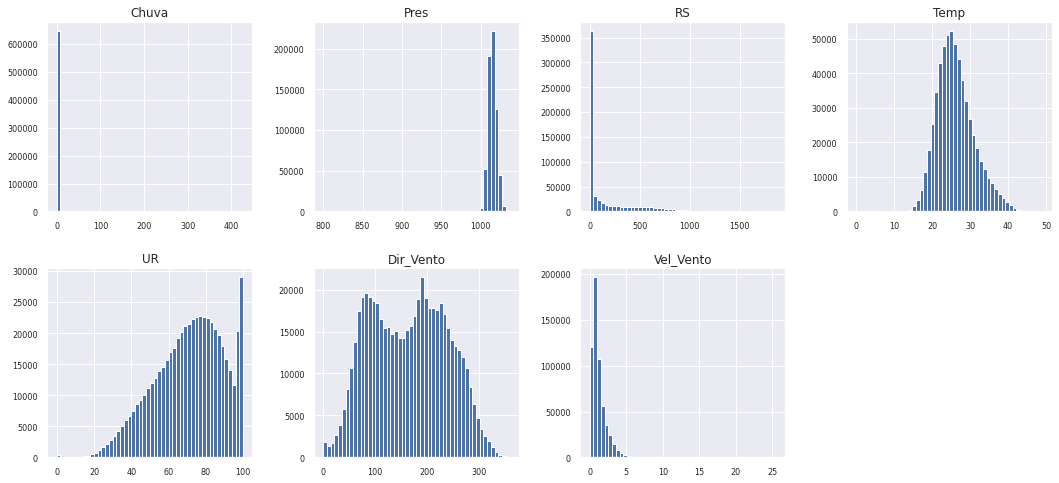

In [8]:
air_data.hist(column = ['Chuva', 'Pres', 'RS', 'Temp', 'UR', 'Dir_Vento', 'Vel_Vento'], 
              figsize=(18, 8), bins=50, xlabelsize=8, ylabelsize=8, layout = (2,4))
plt.show()

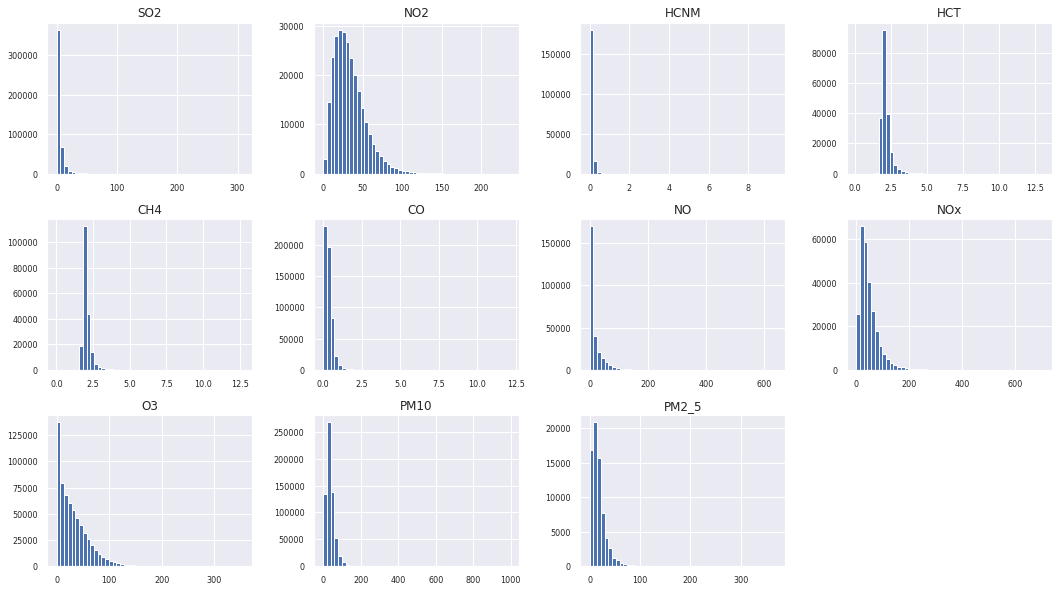

In [9]:
air_data.hist(column = gases, 
              figsize=(18, 10), bins=50, xlabelsize=8, ylabelsize=8, layout = (3,4))
plt.show()

We can observe the variables during the time too.

In [16]:
air_data.Data = pd.to_datetime(air_data.Data) 

We can see that the years 2011 and 2021 have less observations than the others. We will disconsider the year of 2011 for that reason. We must also remember since 2020 we are facing a pandemic. 

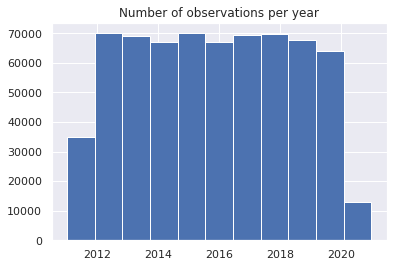

In [18]:
air_data.Data.apply(lambda x: x.year).hist(bins=11)
plt.title("Number of observations per year")
plt.savefig(IMAGES_FOLDER + 'histogram.eps', bbox_inches = 'tight')

In [12]:
air_data["year"] = air_data.Data.apply(lambda x: x.year)
air_data["month"] = air_data.Data.apply(lambda x: x.month)
air_data["day"] = air_data.Data.apply(lambda x: x.day)
air_data["hour"] = air_data.Data.apply(lambda x: x.hour)
air_data.drop(labels = ['Data'], axis = 1, inplace = True)

air_data = air_data[air_data.year != 2011]

In [32]:
air_data[air_data.year == 2011]

,CodNum,Chuva,Pres,RS,Temp,UR,Dir_Vento,Vel_Vento,SO2,NO2,...,NOx,O3,PM10,PM2_5,Lat,Lon,year,month,day,hour
103079,3,0.2,1009.33,1.57,21.81,84.50,250.67,0.34,NaN,NaN,...,NaN,17.89,10.00,NaN,-22.908344,-43.178152,2011,1,1,0
103080,3,0.0,1009.00,1.40,21.79,84.73,121.17,0.92,NaN,NaN,...,NaN,12.44,11.00,NaN,-22.908344,-43.178152,2011,1,1,1
103081,3,0.2,1008.17,1.37,21.44,85.70,85.67,1.30,NaN,NaN,...,NaN,18.97,38.00,NaN,-22.908344,-43.178152,2011,1,1,2
103082,3,0.0,1008.00,1.30,21.17,88.57,85.33,1.33,NaN,NaN,...,NaN,11.08,8.00,NaN,-22.908344,-43.178152,2011,1,1,3
103083,3,0.2,1008.00,1.32,21.25,89.28,73.00,0.82,NaN,NaN,...,NaN,11.28,10.00,NaN,-22.908344,-43.178152,2011,1,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395813,8,0.4,1008.05,11.35,23.50,93.05,217.00,1.65,0.28,NaN,...,NaN,22.74,27.76,NaN,-22.924915,-43.232657,2011,12,31,19
395814,8,1.0,1008.63,11.20,22.51,98.06,197.83,0.58,0.27,NaN,...,NaN,19.22,28.22,NaN,-22.924915,-43.232657,2011,12,31,20
395815,8,1.2,1008.87,11.20,21.95,98.41,183.67,0.07,0.07,NaN,...,NaN,19.07,26.62,NaN,-22.924915,-43.232657,2011,12,31,21
395816,8,0.4,1008.67,11.07,21.66,98.41,200.33,0.00,0.00,NaN,...,NaN,26.42,23.37,NaN,-22.924915,-43.232657,2011,12,31,22


We observe that O3 and SO2 are increasing its emisions, while the others are decreasing or remaining nearly constant. 

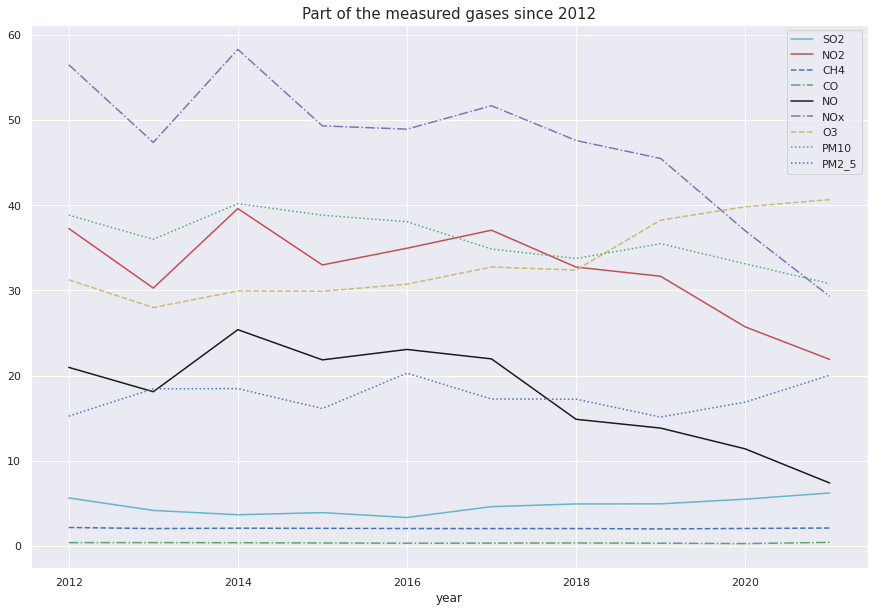

In [13]:
part_gases = ['SO2', 'NO2', 'CH4', 'CO', 'NO', 'NOx', 'O3', 'PM10', 'PM2_5']
air_data.groupby("year").mean()[part_gases].plot(figsize = (15,10), 
                                                 style = ['c-','r-','b--','g-.', 'k-','m-.', 'y--', 'g:', 'b:'])
plt.legend(loc='upper right')
plt.title("Part of the measured gases since 2012", fontsize = 15)
plt.show()

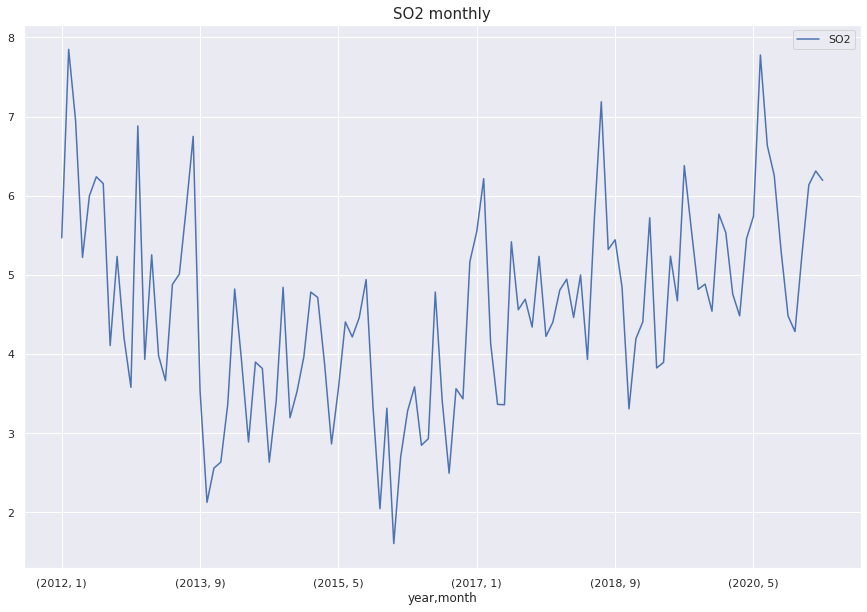

In [14]:
air_data.groupby(by = ["year", 'month']).mean()[ ['SO2']].plot(figsize = (15,10))
plt.legend(loc='upper right')
plt.title("SO2 monthly", fontsize = 15)
plt.show()